# Importing Libraries

In [ ]:
from __future__ import division
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
import keras
import tensorflow as tf
from keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization,Embedding
from keras.layers import Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten
from keras.models import Sequential
from keras import Model
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.utils import plot_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers.legacy import RMSprop
from matplotlib import pyplot
import sys

# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
img_path = '/content/gdrive/MyDrive/CWGAN/tf/'
MODEL_NAME = 'CWGAN'
DATA_BASE_DIR = 'dataset/images/'
OUTPUT_PATH = os.path.join(img_path,'outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join(img_path,"logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

TARGET_IMG_SIZE = 28 # Scale images to this size

BATCH_SIZE = 64
NOISE_DIM = 100
LABEL_DIM = 50
LAMBDA = 10 # For gradient penalty

EPOCHs = 5
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 10 # Save checkpoint at every n epoch

N_CRITIC = 5 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.00005 # Minimum value of learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

IMG_WIDTH = IMG_HEIGHT = 28

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [ ]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	Y = trainy
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return (X,Y)
x_data,y_data = load_real_samples()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_data.shape

(60000, 28, 28, 1)

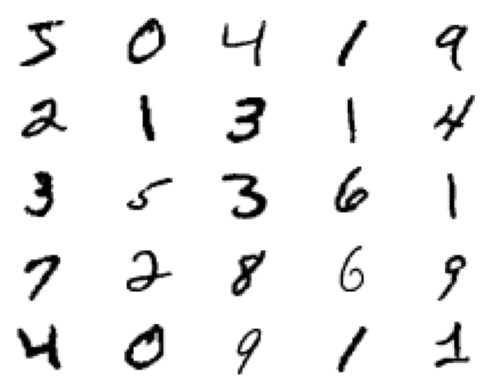

In [ ]:

for i in range(5 * 5):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(x_data[i, :, :, 0], cmap='gray_r')

# Prepare dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_data,y_data))

In [ ]:
# train_dataset = train_dataset.repeat()
train_data = train_dataset.shuffle(1000).batch(BATCH_SIZE)

In [ ]:
sample_img = next(iter(train_data))

In [ ]:
x,y = next(iter(train_data))

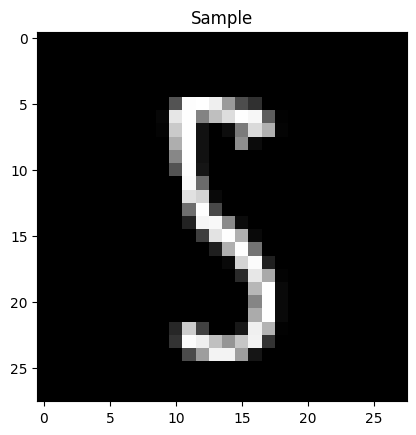

In [ ]:
sample_img = x
plt.title('Sample')
plt.imshow(np.clip(sample_img[0] * 0.5 + 0.5, 0, 1),cmap='gray')

In [ ]:
OUTPUT_PATH

'/content/gdrive/MyDrive/CWGAN/tf/outputs/CWGAN'

In [ ]:
def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    '''
        Generate images and plot it.
    '''
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

In [ ]:
labels = np.asarray([x for _ in range(2) for x in range(10)])

In [ ]:
sample_labels = labels

(20, 100)
1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


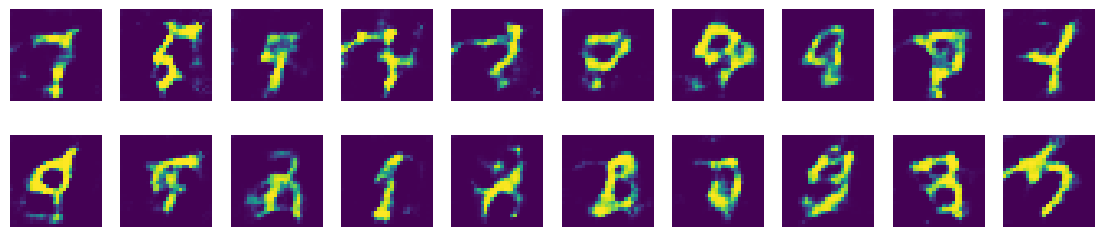

In [ ]:
num_examples_to_generate = 20
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
print(sample_noise.shape)
# We will reuse this seed overtime

generate_and_save_images(generator, 0, [sample_noise,sample_labels], figure_size=(14,3), subplot=(2,10), save=True, is_flatten=False)

# Define Generator and Critic Model

In [ ]:

def CGAN_generator(input_z_shape=NOISE_DIM,n_classes =10):

    # label input
    input_label = Input(shape=(1,))
    # embedding for categorical input
    condition_layer = Embedding(n_classes, 50)(input_label)
    n_nodes = 7*7
    # linear multiplication
    condition_layer = Dense(n_nodes)(condition_layer)
    # reshape to additional channel
    condition_layer = Reshape((7, 7, 1))(condition_layer)

    input_z_layer = Input(input_z_shape)
    n_nodes = 128 * 7 * 7
    z = Dense(n_nodes, use_bias=False)(input_z_layer)
    z =Reshape((7, 7, 128))(z)

    merge = Concatenate()([z, condition_layer])

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(merge)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Conv2D(1, (7, 7), padding='same', use_bias=False, activation="tanh",
                             kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    model = Model(inputs=[input_z_layer,input_label], outputs=output)
    return model

def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 1),n_classes=10):

        # label input
    input_label = Input(shape=(1,))
    # embedding for categorical input
    condition_layer = Embedding(n_classes, 50)(input_label)
    # scale up to image dimensions with linear activation
    n_nodes = input_x_shape[0] * input_x_shape[1]
    condition_layer = Dense(n_nodes)(condition_layer)
    # reshape to additional channel
    condition_layer = Reshape((input_x_shape[0], input_x_shape[1], 1))(condition_layer)

    input_image = Input(input_x_shape)
     # concat label as a channel
    merge = Concatenate()([input_image, condition_layer])

    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(merge)

    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)

    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)

    output = Dense(1,activation='sigmoid')(x)

    model = Model(inputs=[input_image,input_label], outputs=output)

    return model

In [ ]:
generator = CGAN_generator()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 6272)                 627200    ['input_2[0][0]']             
                                                                                              

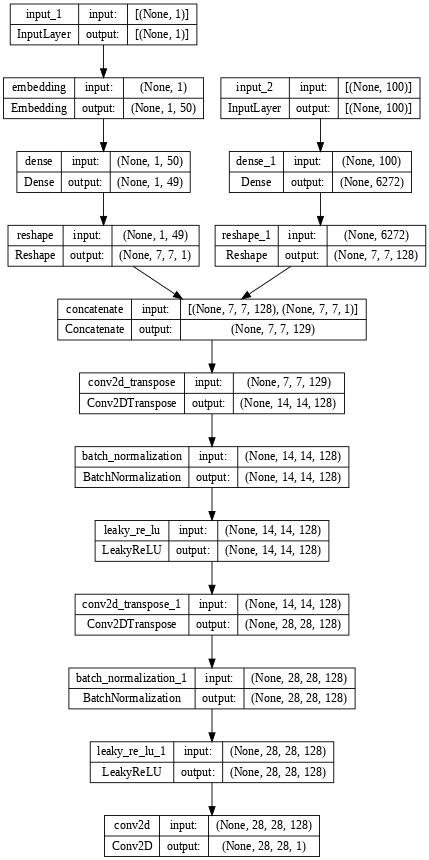

In [ ]:
generator.summary()
# Require extra packages to plot model
plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
discriminator = CGAN_discriminator()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1, 784)               39984     ['embedding_1[0][0]']         
                                                                                                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                            

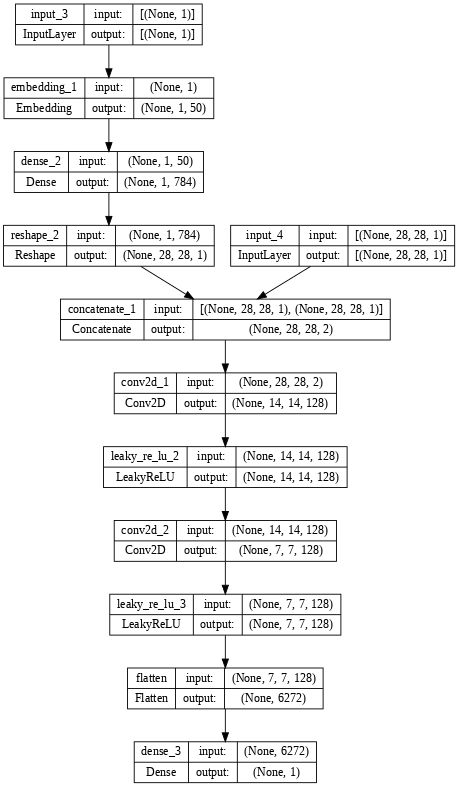

In [ ]:
discriminator.summary()
# Require extra packages to plot model
plot_model(discriminator, show_shapes=True, dpi=64)

# Set Optimizers and Checkpoints

In [ ]:
# Optimizers
D_optimizer = RMSprop(learning_rate=0.00005)
G_optimizer = RMSprop(learning_rate=0.00005)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    '''
        Calculate new learning rate using decay factor
    '''
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [ ]:
checkpoint_path = os.path.join(img_path,"checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

# Training steps

In [ ]:
creal_loss,cfake_loss,g_loss ,d_loss= list(), list(), list(),list()

In [ ]:
cfake_tmp,creal_tmp,dloss_tmp = list(),list(),list()

In [ ]:
@tf.function
def WGAN_GP_train_d_step(real_image,labels,cfake_tmp,creal_tmp,dloss_tmp, batch_size, step):
    '''
        One discriminator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''

    noise = tf.random.normal([batch_size, NOISE_DIM])
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    ###################################
    # Train D
    ###################################
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator([noise,labels], training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator([fake_image_mixed,labels], training=True)

        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))

        fake_pred = discriminator([fake_image,labels], training=True)
        real_pred = discriminator([real_image,labels], training=True)

        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
        cfake_tmp.append(tf.reduce_mean(fake_pred))
        creal_tmp.append(- tf.reduce_mean(real_pred))
        dloss_tmp.append(D_loss)
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss,
                                            discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)

@tf.function
def WGAN_GP_train_g_step(real_image,labels, batch_size, step):
    '''
        One generator training step

        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''

    noise = tf.random.normal([batch_size, NOISE_DIM])
    ###################################
    # Train G
    ###################################
    with tf.GradientTape() as g_tape:
        fake_image = generator([noise,labels], training=True)
        fake_pred = discriminator([fake_image,labels], training=True)
        G_loss = -tf.reduce_mean(fake_pred)
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss,
                                            generator.trainable_variables)
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients,
                                                generator.trainable_variables))
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    return G_loss

# Train models

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
creal_loss,cfake_loss,g_loss ,d_loss= list(), list(), list(),list()

In [ ]:
cfake_tmp,creal_tmp,dloss_tmp = list(),list(),list()

1/1 [==============================] - 0s 30ms/step


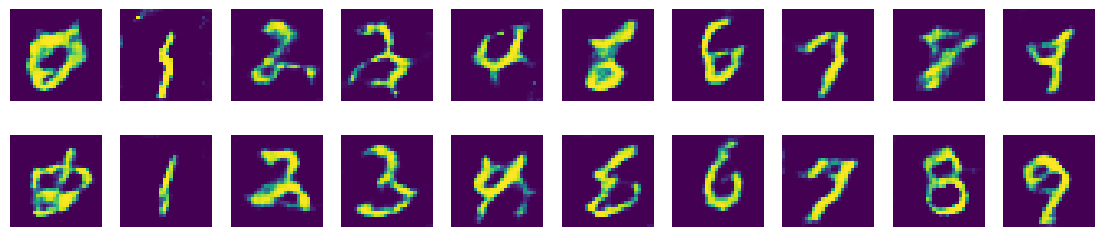

Time taken for epoch 5 is 108.39354109764099 sec

Saving checkpoint for epoch 5 at /content/gdrive/MyDrive/CWGAN/tf/checkpoints/tensorflow/CWGAN/ckpt-1


In [ ]:
current_learning_rate = LR
trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    #current_learning_rate = learning_rate_decay(current_learning_rate)
   # print('current_learning_rate %f' % (current_learning_rate,))
    set_learning_rate(current_learning_rate)
    cfake_tmp,creal_tmp,dloss_tmp = list(),list(),list()
    for step, (image,labels) in enumerate(train_data):
        current_batch_size = image.shape[0]
        # Train critic (discriminator)
        WGAN_GP_train_d_step(image,labels,cfake_tmp,creal_tmp,dloss_tmp, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))

        n_critic_count += 1
        if n_critic_count >= N_CRITIC:
            cfake_loss.append(mean(cfake_tmp))
            creal_loss.append(mean(creal_tmp))
            d_loss.append(mean(dloss_tmp))
            cfake_tmp,creal_tmp,dloss_tmp = list(),list(),list()
            # Train generator
            loss = WGAN_GP_train_g_step(image,labels, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            g_loss.append(loss)
            n_critic_count = 0

        if step % 20 == 0:
            print ('.', end='')

    # Clear jupyter notebook cell output
    clear_output(wait=True)
    # Using a consistent sample so that the progress of the model is clearly visible.
    generate_and_save_images(generator, epoch, [sample_noise,sample_labels],  figure_size=(14,3), subplot=(2,10), save=True, is_flatten=False)

    if epoch % SAVE_EVERY_N_EPOCH == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             ckpt_save_path))


    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))

# Save at final epoch
ckpt_save_path = ckpt_manager.save()
print ('Saving checkpoint for epoch {} at {}'.format(EPOCHs,
                                                        ckpt_save_path))


In [ ]:
import matplotlib.pyplot as plt
def plot_history(d1_hist, d2_hist, d_hist,g_hist):
  plt.plot(d1_hist,label="crit_real")
  plt.plot(d2_hist,label="crit_fake")
	# plot history
  plt.plot(d_hist, label='crit_total')
  plt.plot(g_hist, label='gen')

  plt.legend()
  plt.savefig(img_path + 'plot_line_plot_loss.png')
  plt.close()

32/32 [==============================] - 13s 385ms/step


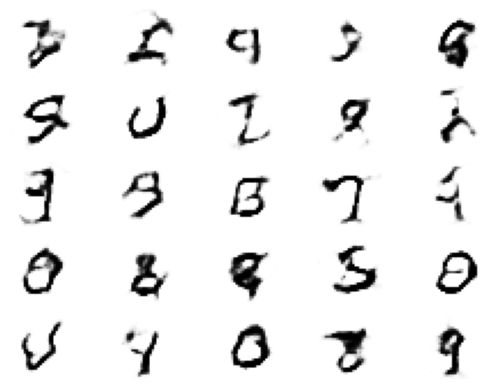

In [ ]:
Xfake, _ = generate_fake_samples(generator, 100, 1000)

labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([sample_laten, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
# save_plot(X, 10)

	# scale from [-1,1] to [0,1]
Xfake = Xfake[100:125]
Xfake = (Xfake + 1) / 2.0
# plot images
for i in range(5 * 5):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(Xfake[i, :, :, 0], cmap='gray_r')

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 z_input = x_input.reshape(n_samples, latent_dim)
 # generate labels

 labels = np.asarray([x for _ in range(10) for x in range(10)])
 return z_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [ ]:
plot_history(creal_loss,cfake_loss,d_loss,g_loss)

In [ ]:
gen_path = img_path+'generator_cwgan_model.keras'
generator.save(gen_path)
critic_path = img_path+'critic_cwgan_model.keras'
discriminator.save(critic_path)
# gan_path = img_path+'gan_model.keras'
# gan_model.save(gan_path)

# WGAN and CWGAN Evaluation

In [ ]:
def image_grid(images, fig):
    # Create a figure to contain the plot.
    for i in range(64):
        # Start next subplot.
        axs = fig.add_subplot(8, 8, i + 1)
        axs.set_xticks([])
        axs.set_yticks([])
        axs.imshow(np.clip(images[i] * 0.5 + 0.5, 0, 1),cmap='gray')

In [ ]:
from tensorflow import keras
critic_model = keras.models.load_model('/content/gdrive/MyDrive/WGANGP/tf/critic_model.keras')
generator_model = keras.models.load_model('/content/gdrive/MyDrive/WGANGP/tf/generator_model.keras')

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	print(X)
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

	pyplot.show()
	#print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# Use new sample to see the performance of the model.
latent_points = tf.random.normal([100, NOISE_DIM])
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
prediction = generator_model.predict(latent_points)

4/4 [==============================] - 1s 168ms/step


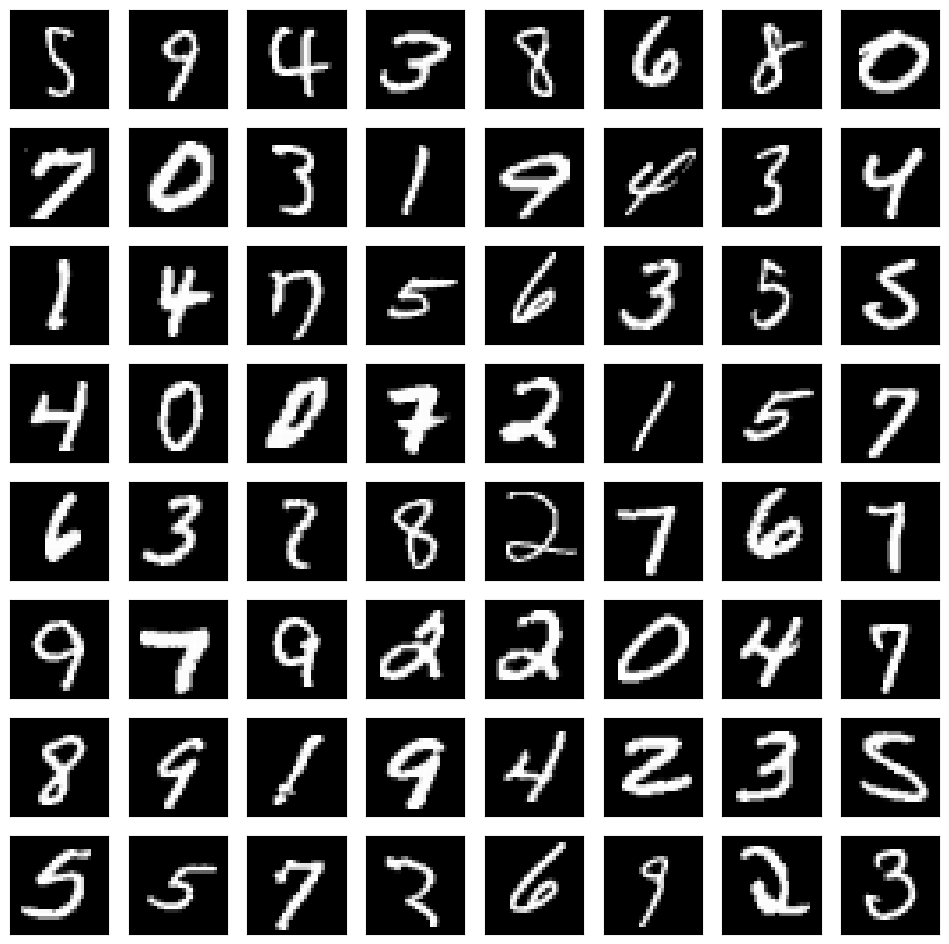

In [ ]:
# Plot the real images for dataset
fig1 = plt.figure(figsize=(12,12))
image_grid(sample_img.numpy()[:64], fig1)
plt.show()

###WGAN Predictions

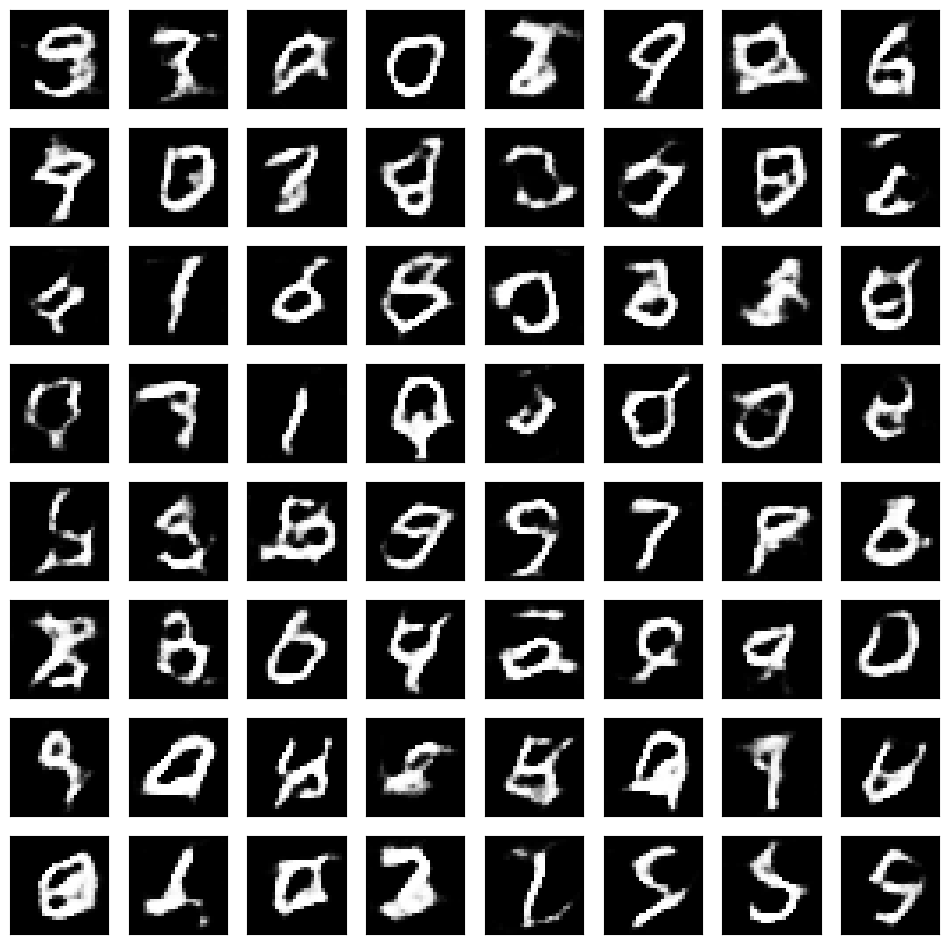

In [ ]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)
#WGAN predictions

###CWGAN Prediction

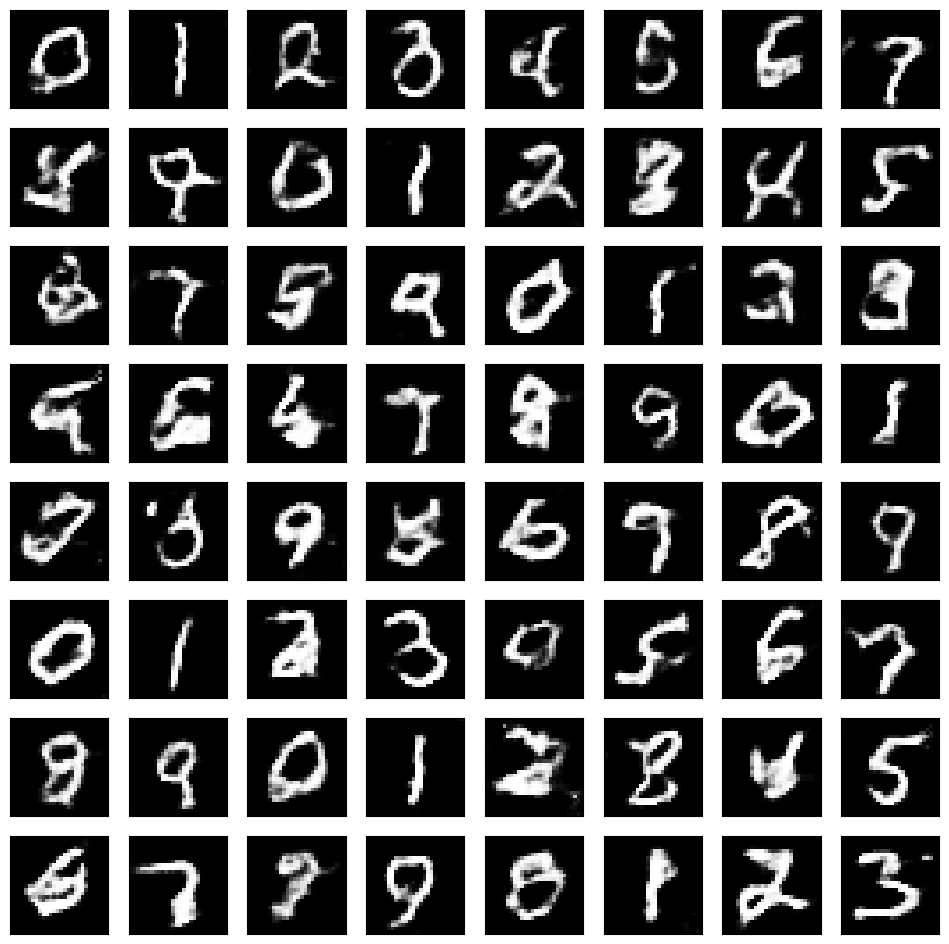

In [ ]:
# Plot the fake images from the last epoch
fig2 = plt.figure(figsize=(12,12))
image_grid(prediction, fig2)

In [ ]:
critic = critic_model
critic.layers[6].output

func = K.function([critic.get_layer(index=0).input], critic.get_layer(index=6).output)
layerOutput = func(Xfake)  # input_data is a numpy array
print(layerOutput)

[[2.063146  ]
 [0.1341442 ]
 [0.13402805]
 [1.4643639 ]
 [1.3551787 ]
 [0.8921936 ]
 [1.4807425 ]
 [0.59922695]
 [0.3118459 ]
 [1.0564833 ]
 [1.3795462 ]
 [2.0674112 ]
 [1.7201339 ]
 [1.0293868 ]
 [0.8209219 ]
 [1.7993993 ]
 [2.0956678 ]
 [1.6478735 ]
 [1.2168437 ]
 [1.7616215 ]
 [1.5341003 ]
 [1.7464995 ]
 [1.355319  ]
 [0.60403186]
 [2.7882264 ]]


# TSNE


In [ ]:
# Importing seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold

In [ ]:
X_real,y_real = x_data[:1000],y_data[:1000]

In [ ]:
x_data= X_real
y= x_data.reshape(-1,784)
y.shape

(1000, 784)

In [ ]:

# dimensionality reduction using t-SNE
tsne = manifold.TSNE(n_components=2,perplexity=3, random_state=42)
# fit and transform
mnist_tr = tsne.fit_transform(y)#Real data mnist_tr

In [ ]:
# Use new sample to see the performance of the model.

generator_model = keras.models.load_model( '/content/gdrive/MyDrive/CWGAN/tf/generator_cwgan_model.keras')


latent_points = tf.random.normal([1000, 100])
labels = np.asarray([x for _ in range(100) for x in range(10)])
# generate images
predictions = generator_model.predict([latent_points,labels])

y= predictions.reshape(-1,784)

tsne = manifold.TSNE(n_components=2,perplexity=3, random_state=42)

generated_mnist = tsne.fit_transform(y)

32/32 [==============================] - 4s 9ms/step


In [ ]:
tsne_df = pd.DataFrame(np.column_stack((mnist_tr, y_real)), columns=['X', 'Y', "Targets"])

tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)

In [ ]:
tsne_df_generated = pd.DataFrame(np.column_stack((generated_mnist, labels)), columns=['X', 'Y', "Targets"])

tsne_df_generated.loc[:, "Targets"] = tsne_df_generated.Targets.astype(int)

In [ ]:
tsne_df.head(10)

,X,Y,Targets
0,-4.678288,22.578863,5
1,74.692688,9.522799,0
2,20.340248,-54.641064,4
3,-77.030571,-2.601074,1
4,-25.087160,-32.507664,9
5,21.130009,-22.028564,2
6,1.814064,0.366415,1
7,16.281569,63.500626,3
8,-7.706576,10.094511,1
9,10.262510,-73.313820,4


In [ ]:
tsne_df_generated

,X,Y,Targets
0,-17.836082,-76.249512,0.0
1,-46.466831,-46.125652,1.0
2,50.798923,17.208204,2.0
3,91.186638,8.086773,3.0
4,10.797283,56.276039,4.0
...,...,...,...
995,-8.904323,-11.214691,5.0
996,56.469265,31.156321,6.0
997,-73.251305,-8.628052,7.0
998,-36.522892,-52.885620,8.0


<Figure size 1000x800 with 0 Axes>

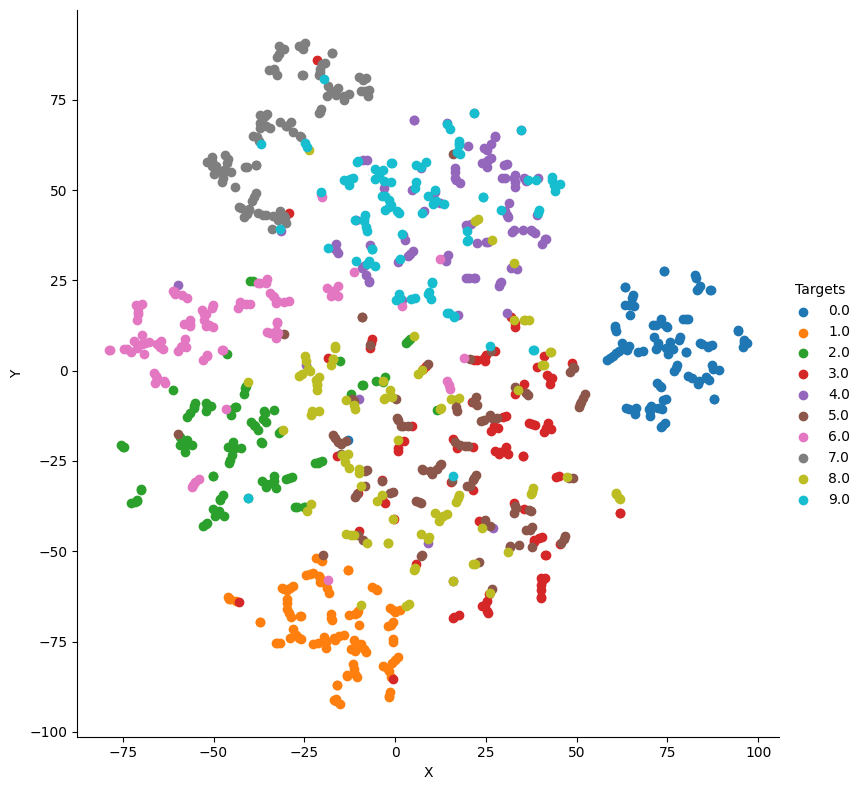

In [ ]:
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df_generated, hue='Targets', height=8)

g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()

<Figure size 1000x800 with 0 Axes>

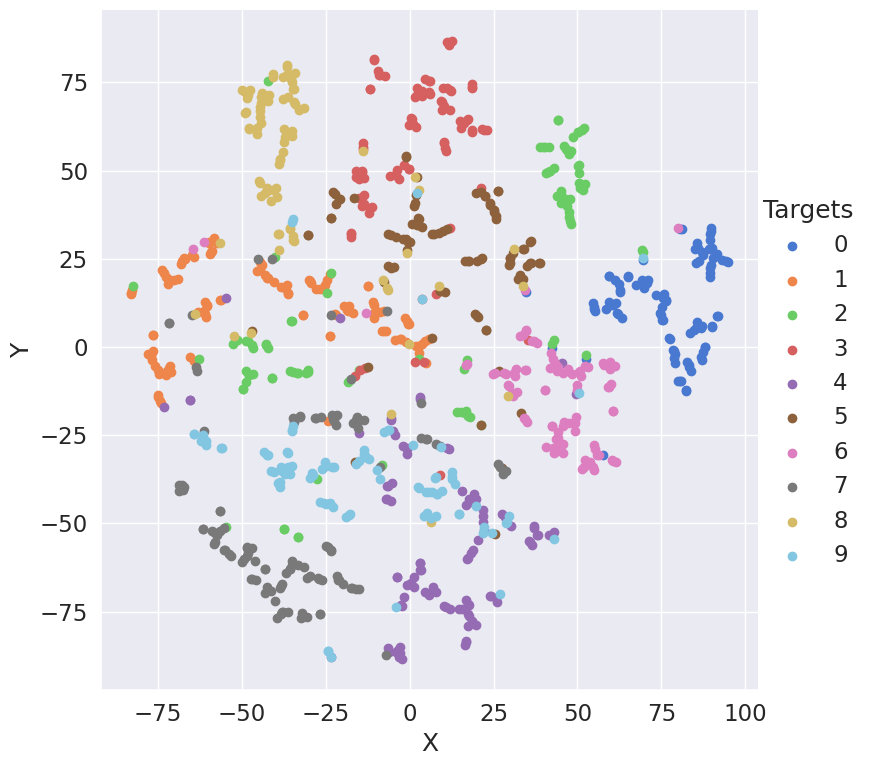

In [ ]:
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8)

g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()

# Plotting TSNE of real and generated data together

In [ ]:
x_data= X_real
y= x_data.reshape(-1,784)

predictions = generator_model.predict([latent_points,labels])

ypred= predictions.reshape(-1,784)

yfinal = np.concatenate((y,ypred),axis=0)
tsne = manifold.TSNE(n_components=2,perplexity=3, random_state=42)

combined_mnist = tsne.fit_transform(yfinal)


32/32 [==============================] - 0s 5ms/step


In [ ]:
tsne_df_combined = pd.DataFrame(np.column_stack((combined_mnist, np.concatenate((y_real,labels)))), columns=['X', 'Y', "Targets"])

tsne_df_combined.loc[:, "Targets"] = tsne_df_combined.Targets.astype(int)

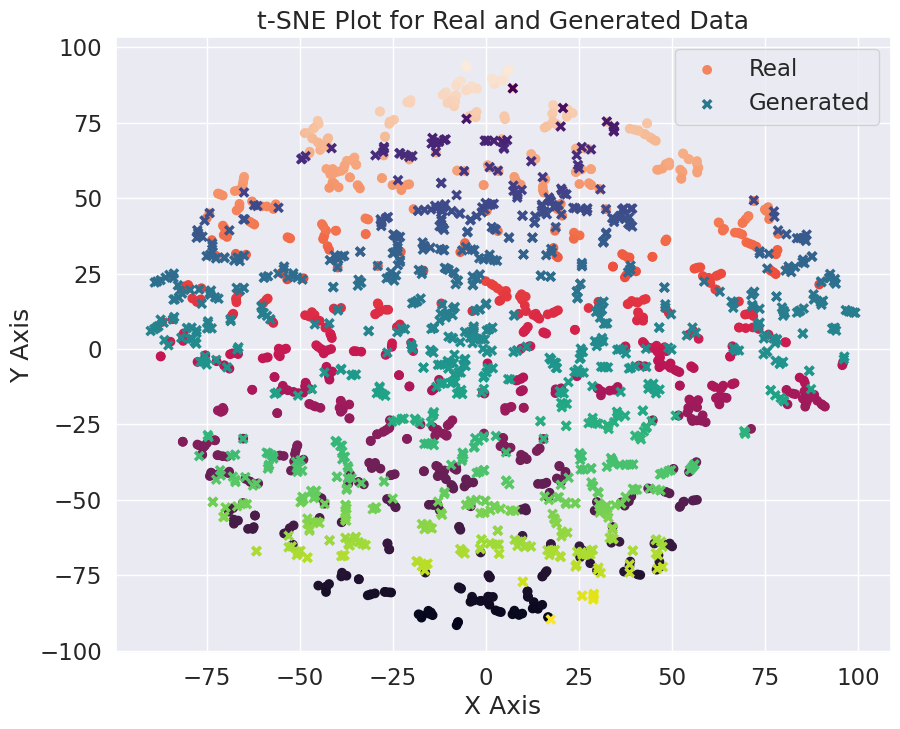

In [ ]:
plt.figure(figsize=(10, 8))

# Plotting the first DataFrame with a specific marker
plt.scatter(tsne_df_combined['X'][:1000], tsne_df_combined['Y'][:1000], label='Real', marker='o',
            c=( tsne_df_combined['Y'][:1000]) )

# Plotting the second DataFrame with a different marker
plt.scatter(tsne_df_combined['X'][1000:], tsne_df_combined['Y'][1000:], label='Generated', marker='x',cmap = "viridis",
            c=( -tsne_df_combined['Y'][1000:]))

# Adding a legend
plt.legend()

# Adding labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('t-SNE Plot for Real and Generated Data')

# Display the plot
plt.show()

In [ ]:
tsne_df_combined[:1000]

<Figure size 1000x800 with 0 Axes>

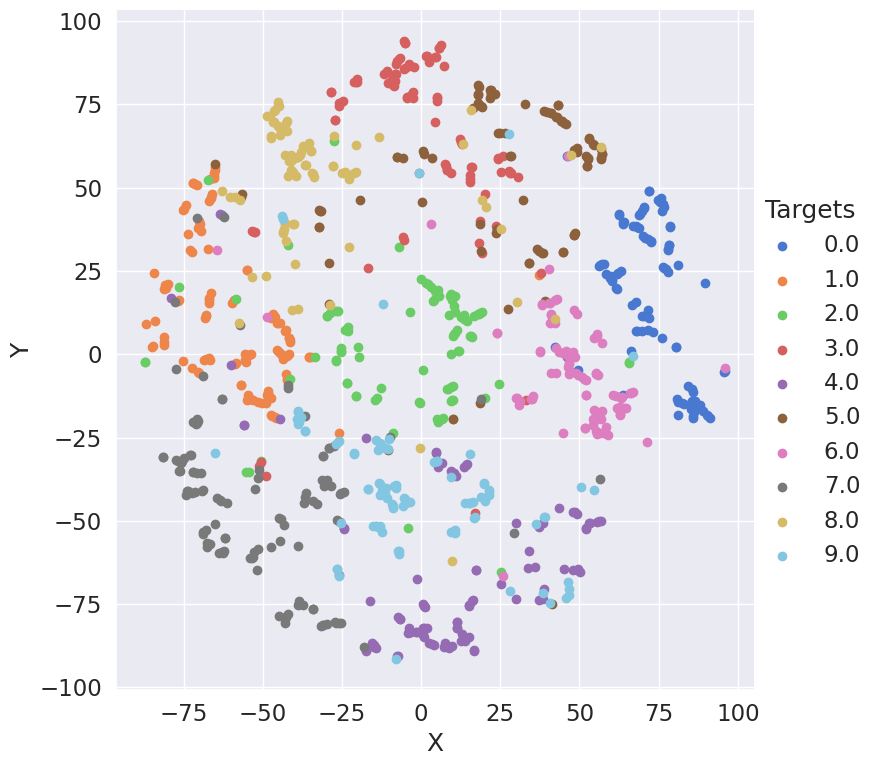

In [ ]:
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df_combined[:1000], hue='Targets', height=8)

g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()